# Sections

[Objective](#Objective)  
[Setup](#Setup)  
[Load data](#Load-data)  
[Modelling](#Modelling)  

- [Examine prices in different areas](#Examine-prices-in-different-areas)  
- [Linear regression with just size and location](#Linear-regression-with-just-size-and-location)  
- [Linear regression with apartment features](#Linear-regression-with-apartment-features)
- [Cross-validate and regularize](#Cross-validate-and-regularize)
- [Adjust for non-linear target](#Adjust-for-non-linear-target)
- [Significant features](#Significant-features)
- [Price caps](#Price-caps)

[Scratchpad](#Scratchpad)

# Objective
[Back to top](#Sections)

#### Predict the price of a New York City apartment.

This project uses data from this Kaggle <a href='https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data'>competition</a>. The data comes from renthop.com, an apartment listing website. See ```data_import.ipynb``` for a detailed description of the data.

#  Setup
[Back to top](#Sections)

In [1]:
from __future__ import print_function, division

In [2]:
from collections import namedtuple
from collections import OrderedDict
from collections import Counter
from collections import defaultdict
import numpy as np
import pandas as pd

Load functions for producing nicely formatted output.

In [3]:
# %load utils.py
from IPython.display import display, HTML

def pp_bold(str):
    display(HTML('<b>{}</b>'.format(str)))


def pp_listOflist(l):
    display(HTML(
        u'<table>{}</table>'.format(
            u''.join(u'<tr>{}</tr>'.format(
                u''.join(u'<td>{}</td>'.format(v) for v in sublist)) for sublist in l))))
    

def pp_dict(d, rows=None):
    if not rows or rows >= len(d):
        display(HTML(
            u'<table>{}</table>'.format(
                u''.join(u'<tr><td><b>{}</b></td><td>{}</td></tr>'.format(k, d[k]) for k in d))))
    else:
        nitems = len(d)
        width = -(-nitems // rows)
        i = 0
        list_ = [[] for _ in range(rows)]
        for _ in range(width):
            for row in range(rows):
                if i < nitems:
                    k, v = d.items()[i]
                    list_[row].extend(['<b>{}</b>'.format(k), v])
                i += 1
        pp_listOflist(list_)


def pp_dictOflist(d):
    display(HTML(
        u'<table>{}</table>'.format(
            u''.join(u'<tr><td><b>{}</b></td>{}</tr>'.format(k,
                u''.join(u'<td>{}</td>'.format(v) for v in d[k])) for k in d.keys()))))
    

def pp_dfinfo(df, width=4):
    ncols = len(df.columns)
    width = min(width, ncols)
    depth = -(-ncols // width)
    i = 0
    list_ = [[] for _ in range(depth)]
    for _ in range(width):
        for row in range(depth):
            if i < ncols:
                col = df.columns[i]
                list_[row].extend(['<b>{}</b>'.format(col), df[col].count(), df.dtypes[i]])
            i += 1

    print('{} entries, {} columns'.format(len(df), ncols))
    pp_listOflist(list_)


def pp_counts(series, rows=1, caption=None):
    if caption: pp_bold(caption)
    list_ = [(k, '{:.4f}'.format(v)) for k, v in series.to_dict().items()] 
    dict_ = OrderedDict(sorted(list_, key=lambda x: x[0]))
    pp_dict(dict_, rows)


def pp_progress(s):
    sys.stdout.write('\r{}'.format(s))
    sys.stdout.flush()


## Load data
[Back to top](#Sections)

In [4]:
import pymongo

Connect to MongoD. The **renthop** database contains 50,000 listings from the Kaggle competition training set. The **renthop2** database contains 95,000 listings scrapped directly from renthop.com. See ```web_scraping.ipynb``` for the details of how I scraped the site.

In [5]:
client = pymongo.MongoClient('ec2-34-198-246-43.compute-1.amazonaws.com', 27017)
db = client.renthop2
collection = db.listings
pp_bold('{} listings'.format(collection.count()))

Print one of them.

In [6]:
pp_dict(collection.find_one())

loc,"{u'type': u'Point', u'coordinates': [-73.9741, 40.7447]}"
listing_id,8433360
bathrooms,1.0
description,"Call the Anchor Knights at 212.310.0352! This is a true 2 bedroom just off of 2nd Ave, with gorgeous stainless steel finishes and marble bathroom. Enjoy a dishwasher in the kitchen as well as a private washer/dryer. Hard wood floors and granite counters make this a truly special unit at an unbelievably low price!**Area** D?Agostino?s ? Mercury Bary ? Joshua Tree ? Blockheads ? Starbuck's ? Post Office ? Gristede?s ? Tonic ? Lowe?s Movie Theater **Transportation**: 4, 5, 6 Trains +++ M101, M102, M103, M15, M23, M16 Bus!****IMPORTANT NOTE*** If you are planning on moving in the next 15 days please put ?URGENT? in the subject of the email or state this in a voicemail in order to have your inquiry handled with priority.Please Note: Pictures are of a similar apartment in the same building.All photos, amenities, and descriptions are a direct feed from the brokerage. When calling refer to RentHop MX ID 665180"
created,2017-03-26 21:13:47
url,https://www.renthop.com/listings/e-35th-st/32/8433360
price,3295
bedrooms,2.0
longitude,-73.9741
latitude,40.7447
title,"2BR, 1BA at E 35th St."


### Add MongoDB geospatial index

Listings have 'longitude' and 'latitude' fields. Combine these into an indexed 'loc' field that is compatible with mongoDB's geospatial query operations. To avoid doing this more than once, check first if the field already exists.

In [7]:
from geojson import Point

In [14]:
%%time
if not 'loc' in collection.find_one():
    cursor = collection.find({}, {'longitude':1, 'latitude':1})
    bulk = collection.initialize_ordered_bulk_op()
    for r in cursor:
        bulk.find({'_id' : r['_id']}).update({ '$set' : { 'loc' : Point((r['longitude'], r['latitude']))}})
    bulk.execute()
    collection.create_index([("loc", pymongo.GEOSPHERE)])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 144 ms


## Modelling
[Back to top](#Sections)

### Examine prices in different areas
[Back to top](#Sections)

In [15]:
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

This helper function returns listings in an area defined by a center point and radius.

In [16]:
def find_near(point, distance=500, fields=None):
    result = list(collection.find({'loc' : {'$near' : { '$geometry' : point, '$maxDistance' : distance }}}, fields))
    if result and '_id' in result[0]:
        for r in result:
            r['_id'] = str(r['_id'])
    return result

Here I define some test locations around Manhattan and plot the prices around two of them. As you'd expect, the prices differ dramatically (note the X axis).

In [17]:
METIS_loc = Point((-73.9852, 40.7438))
SEVEN80_loc = Point((-73.9478, 40.8339))
TIMESSQ_loc = Point((-73.9851, 40.7589))
WESTVILLAGE_loc = Point((-73.9954, 40.7341))
HK_loc = Point((-73.9918, 40.7638))

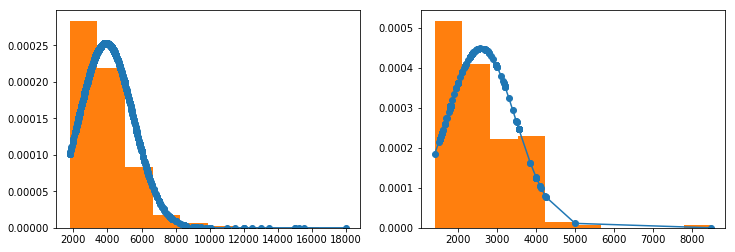

In [18]:
nearby_A = find_near(METIS_loc, 500, {'_id':0, 'price':1})
prices_A = sorted([x['price'] for x in nearby_A if x['price'] < 1e5])
nearby_B = find_near(SEVEN80_loc, 500, {'_id':0, 'price':1})
prices_B = sorted([x['price'] for x in nearby_B if x['price'] < 1e5])

plt.figure(figsize=(12, 4))
plt.subplot(121)
fit = stats.norm.pdf(prices_A, np.mean(prices_A), np.std(prices_A))
plt.plot(prices_A, fit,'-o')
plt.hist(prices_A, normed=True)

plt.subplot(122)
fit = stats.norm.pdf(prices_B, np.mean(prices_B), np.std(prices_B))
plt.plot(prices_B, fit,'-o')
plt.hist(prices_B, normed=True)

plt.show()

###  Linear regression with just size and location
[Back to top](#Sections)

To establish the baseline performance, apply linear regression using location and size alone to predict price. First, use the entire data set.

In [19]:
import statsmodels.api as sm

In [20]:
def get_data(columns, loc=None, distance=500, max_price=1e5):
    if loc:
        df = pd.DataFrame(find_near(loc, distance, columns), columns=columns)
    else:
        df = pd.DataFrame(list(collection.find({}, columns)), columns=columns)
    return df.drop(df[df.price>max_price].index).reset_index(drop=True) # drop price anomalies (see data_exploration.ipynb)

In [21]:
df = get_data(['latitude', 'longitude', 'price', 'bedrooms', 'bathrooms'])
ols = sm.OLS(df['price'], sm.add_constant(df.drop('price', axis=1))).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                 2.038e+04
Date:                Mon, 27 Mar 2017   Prob (F-statistic):               0.00
Time:                        17:03:49   Log-Likelihood:            -8.3355e+05
No. Observations:               95126   AIC:                         1.667e+06
Df Residuals:                   95121   BIC:                         1.667e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1341.6612    752.080     -1.784      0.074   -2815.730     132.407
latitude      31.0691     14.167      2.193      0.028       3.303      58.835
longitude     -2.0752      6.705     -0.309      0.757     -15.218      11.067
bedrooms     347.3432      5.533     62.775      0.000     336.498     358.188
bathrooms   2522.7689     12.226    206.343      0.000    2498.806    2546.732
==============================================================================
Omnibus:                   112769.009   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         69236002.796
Skew:                           5.695   Prob(JB):                         0.00
Kurtosis:                     134.675   Cond. No.                     1.27e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Next, apply regression to listings within a specific area. Observe the performance is better and the model is more stable. This suggests location may be more useful as a way to separate listings into different clusters, rather than as a feature in the model. Further investigation (not shown here) supports this conclusion, so that's how I proceed.

In [22]:
df = get_data(['price', 'bedrooms', 'bathrooms'], TIMESSQ_loc)
X = sm.add_constant(df.drop('price', axis=1))
y = df['price']
ols = sm.OLS(y, X).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     1036.
Date:                Mon, 27 Mar 2017   Prob (F-statistic):          2.71e-277
Time:                        17:03:58   Log-Likelihood:                -11426.
No. Observations:                1410   AIC:                         2.286e+04
Df Residuals:                    1407   BIC:                         2.287e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        566.6830     69.580      8.144      0.000     430.191     703.175
bedrooms     423.1750     27.150     15.586      0.000     369.916     476.434
bathrooms   1930.4467     68.540     28.165      0.000    1795.995    2064.898
==============================================================================
Omnibus:                      528.256   Durbin-Watson:                   1.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3468.642
Skew:                           1.593   Prob(JB):                         0.00
Kurtosis:                       9.993   Cond. No.                         9.07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Examine the residuls and Q-Q plot for this very simple model with just two-features.

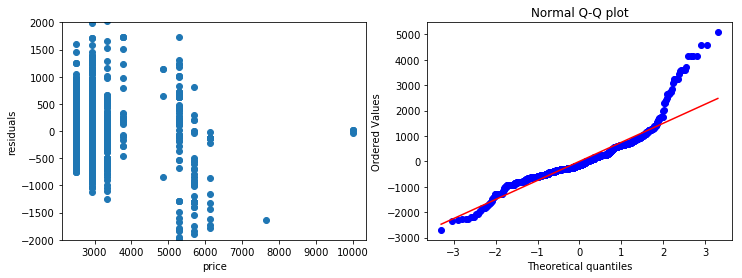

In [23]:
xs = range(len(y))
plt.figure(figsize=(12, 4))

y_pred = ols.predict(X)
plt.subplot(121)
plt.scatter(y_pred, ols.resid)
plt.ylim(-2000, 2000)
plt.xlabel('price')
plt.ylabel('residuals')

plt.subplot(122)
stats.probplot(ols.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

### Linear regression with apartment features
[Back to top](#Sections)

Here we add the rental unit's features to the model.

First extract the top features. See ```data_exploration.ipynb``` for the reasoning behind this logic.

In [44]:
import json
with open('app/synonyms.json') as fd:
    synomyns = json.load(fd)
canon = {alias : term for s in synomyns for term, aliases in s.items() for alias in aliases}

all_features = Counter()
df = pd.DataFrame(list(collection.find({}, ['features']))).dropna()
for l in df.features:
    unit_features = l.lower().replace('-', ' ').split('\n')
    all_features.update([canon.get(f, f) for f in unit_features if f])

del all_features['-']
topFeatures = OrderedDict(filter(lambda x: x[1] > 100, all_features.most_common()))

In [45]:
pp_dict(topFeatures, rows=10)

In [46]:
def get_features_matrix(list_or_iter):
    listings = []
    for features in list_or_iter:
        listings.append({})
        for f in features.lower().replace('-', ' ').split('\n'):
            f = canon.get(f, f)
            if f in topFeatures:
                f_name = 'f_' + f.replace(' ', '_')
                listings[-1][f_name] = 1    
    return pd.DataFrame.from_dict(listings).fillna(0)

Create model with all apartment features. Observe the performance is much improved, but the model is unstable and not all features are significant.

In [47]:
df = get_data(['price', 'bedrooms', 'bathrooms', 'features'], TIMESSQ_loc)
df = df.join(get_features_matrix(df.features)).drop('features', axis=1)

X = sm.add_constant(df.drop('price', axis=1))
y = df['price']

ols = sm.OLS(y, X).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     88.33
Date:                Mon, 27 Mar 2017   Prob (F-statistic):               0.00
Time:                        17:21:17   Log-Likelihood:                -11078.
No. Observations:                1410   AIC:                         2.225e+04
Df Residuals:                    1362   BIC:                         2.250e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

Examine residuls and Q-Q plot.

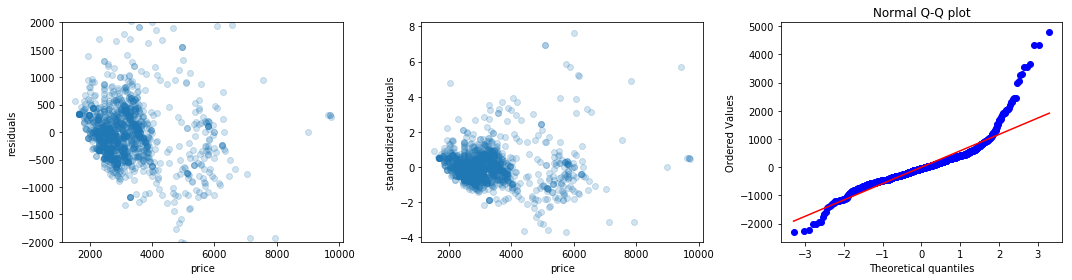

In [48]:
xs = range(len(y))
plt.figure(figsize=(15, 4))

y_pred = ols.predict(X)
resids = ols.resid

plt.subplot(131)
plt.scatter(y_pred, resids, alpha=.2)
plt.ylim(-2000, 2000)
plt.xlabel('price')
plt.ylabel('residuals')

plt.subplot(132)
plt.scatter(y_pred, resids / np.std(resids), alpha=.2)
#plt.ylim(-1.0, 1.0)
plt.xlabel('price')
plt.ylabel('standardized residuals')

plt.subplot(133)
stats.probplot(ols.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

plt.tight_layout()
plt.show()

### Cross-validate and regularize
[Back to top](#Sections)

Now that we have a direction, use cross-validation and regularization to create a robust model.

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

 This helper function scores different regression algorithms.

In [50]:
def eval_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4444)
    scores = {}

    ridge = RidgeCV(cv=5)
    ridge.fit(X_train, y_train)
    scores['Ridge'] = round(ridge.score(X_test, y_test), 3)

    lasso = LassoCV(cv=5)
    lasso.fit(X_train, y_train)
    scores['Lasso'] = round(lasso.score(X_test, y_test), 3)

    elnet = ElasticNetCV(cv=5)
    elnet.fit(X_train, y_train)
    scores['ElasticNet'] = round(elnet.score(X_test, y_test), 3)

    dtree = DecisionTreeRegressor(max_depth=10)
    dtree.fit(X_train, y_train)
    scores['Decision Tree'] = round(dtree.score(X_test, y_test), 3)
    
    # Also try plain LinearRegression after using p-values to 
    # select important features.

    ols = sm.OLS(y_train, sm.add_constant(X_train)).fit()
    significant_features = [f for f in ols.pvalues.index if f != 'const' and ols.pvalues[f] < 0.01]
    ols_X_train = X_train[significant_features]
    ols_scores = cross_val_score(LinearRegression(), ols_X_train, y_train, cv=5, scoring='r2')
    scores['LinearRegression'] = np.round(np.mean(ols_scores), 3)
    return scores

Check the model performance on several Manhattan locations.

In [51]:
scores = defaultdict(list)
for loc in [TIMESSQ_loc, METIS_loc, SEVEN80_loc, WESTVILLAGE_loc, HK_loc]:
    df = get_data(['price', 'bedrooms', 'bathrooms', 'features'], loc)
    df = df.join(get_features_matrix(df.features)).drop('features', axis=1)
    X = df.drop('price', axis=1)
    y = df['price']
    for model, score in eval_models(X, y).items():
        scores[model].append(score)

pp_dictOflist(scores)

ElasticNet,0.462,0.363,0.779,0.211,0.554
Ridge,0.71,0.605,0.896,0.501,0.723
Lasso,0.705,0.606,0.88,0.495,0.722
LinearRegression,0.719,0.564,0.616,0.383,0.607
Decision Tree,0.457,0.542,-0.905,0.039,-0.088


### Adjust for non-linear target
[Back to top](#Sections)

This chart illustrates how prices behave non-linearly.

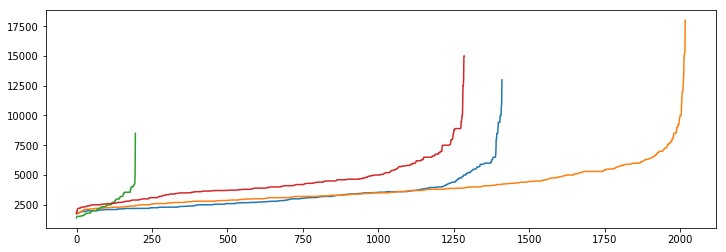

In [52]:
plt.figure(figsize=(12, 4))
for loc in [TIMESSQ_loc, METIS_loc, SEVEN80_loc, WESTVILLAGE_loc]:
    df = get_data(['price'], loc)
    df = df[df.price<20000].sort_values(by='price')
    plt.plot(range(len(df)), df.price)
plt.show()

Maybe we need a log relationship in our model? Re-evalate the regression algorithms with the target as **log<sub>10</sub>(price)**. Observe the performance is much improved, and Ridge performs best of all the algorithms.

In [54]:
scores = defaultdict(list)
for loc in [TIMESSQ_loc, METIS_loc, SEVEN80_loc, WESTVILLAGE_loc, HK_loc]:
    df = get_data(['price', 'bedrooms', 'bathrooms', 'features'], loc)
    df = df.join(get_features_matrix(df.features)).drop('features', axis=1)
    X = df.drop('price', axis=1)
    y = np.log10(df['price'])
    for model, score in eval_models(X, y).items():
        scores[model].append(score)

pp_dictOflist(scores)

ElasticNet,0.744,0.674,0.899,0.643,0.768
Ridge,0.745,0.675,0.897,0.646,0.768
Lasso,0.744,0.674,0.899,0.644,0.768
LinearRegression,0.735,0.641,0.751,0.49,0.748
Decision Tree,0.667,0.651,0.113,0.484,0.641


Compare the residuals and Q-Q plot of two Ridge models, one targeting **price** and the other targetting **log<sub>10</sub>(price)**. First price:

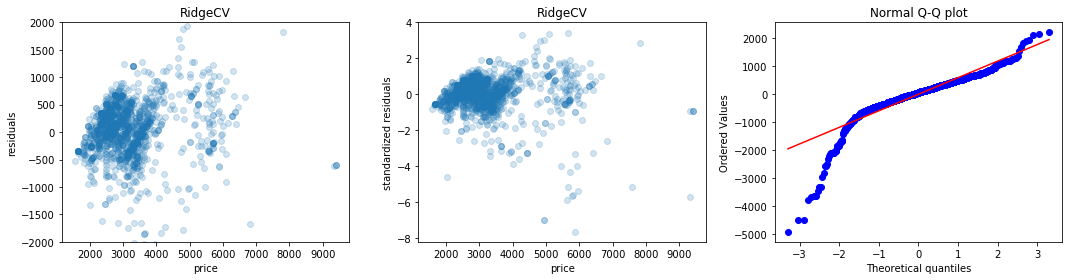

In [58]:
df = get_data(['price', 'bedrooms', 'bathrooms', 'features'], TIMESSQ_loc)
df = df.join(get_features_matrix(df.features)).drop('features', axis=1)

X = df.drop('price', axis=1)
y = df['price']

elnet = RidgeCV(cv=5)
elnet.fit(X, y)
y_pred = elnet.predict(X)
resids = y_pred - y

plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.scatter(y_pred, resids, alpha=.2)
plt.ylim(-2000, 2000)
plt.xlabel('price')
plt.ylabel('residuals')
plt.title('RidgeCV')

plt.subplot(132)
plt.scatter(y_pred, resids / np.std(resids), alpha=.2)
plt.xlabel('price')
plt.ylabel('standardized residuals')
plt.title('RidgeCV')

plt.subplot(133)
stats.probplot(resids, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.tight_layout()
plt.show()

And log10(price). It's clear the log works better.

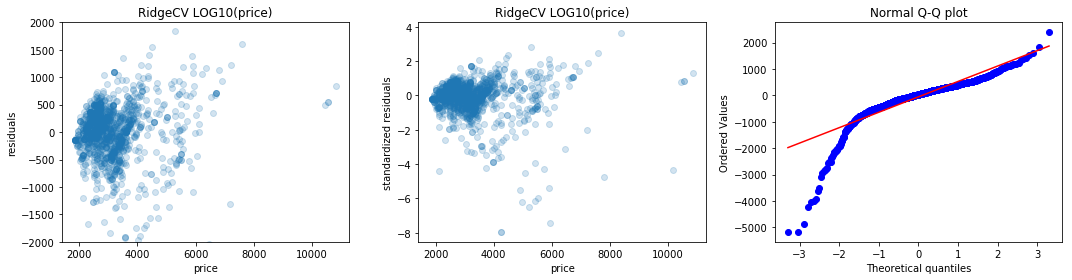

In [59]:
df = get_data(['price', 'bedrooms', 'bathrooms', 'features'], TIMESSQ_loc)
df = df.join(get_features_matrix(df.features)).drop('features', axis=1)

X = df.drop('price', axis=1)
y = df['price']

elnet = RidgeCV(cv=5)
elnet.fit(X, np.log10(y))
y_pred = np.power(10, elnet.predict(X))
resids = y_pred - y

plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.scatter(y_pred, resids, alpha=.2)
plt.ylim(-2000, 2000)
plt.title('RidgeCV LOG10(price)')
plt.xlabel('price')
plt.ylabel('residuals')

plt.subplot(132)
plt.scatter(y_pred, resids / np.std(resids), alpha=.2)
plt.xlabel('price')
plt.ylabel('standardized residuals')
plt.title('RidgeCV LOG10(price)')

plt.subplot(133)
stats.probplot(resids, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.tight_layout()
plt.show()

Plot some actual versus predicted prices.

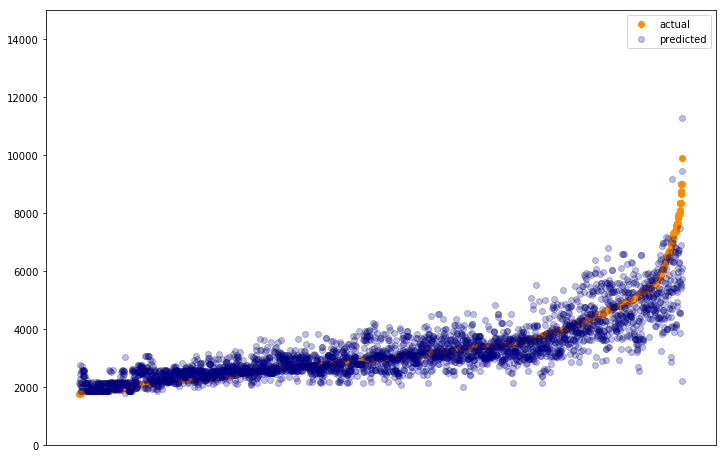

In [69]:
df = get_data(['price', 'bedrooms', 'bathrooms', 'features'], HK_loc)
df = df.join(get_features_matrix(df.features)).drop('features', axis=1)
df = df.sort_values(by='price')

X = df.drop('price', axis=1)
y = df['price']

ridge = RidgeCV(cv=5)
ridge.fit(X, np.log10(y))
y_pred = np.power(10, elnet.predict(X))

xs = range(len(y))
plt.figure(figsize=(12, 8))
plt.scatter(xs, y, color='darkorange', label='actual')
plt.scatter(xs, y_pred, color='navy',label='predicted', alpha=0.25)
plt.xticks([], [])
plt.ylim(0, 15000)
plt.legend()
plt.show()

### Significant features
[Back to top](#Sections)

What are the significant features?

In [62]:
lst = [(elnet.coef_[i], col) for i, col in enumerate(X.columns) if abs(ridge.coef_[i]) > 0.001]
for t in sorted(lst, reverse=True):
    print('{:25s} {:>8.4f}'.format(t[1], t[0]))

bathrooms                   0.0872
bedrooms                    0.0779
f_furnished                 0.0604
f_doorman                   0.0527
f_washer_and_dryer          0.0442
f_by_owner                  0.0353
f_high_ceilings             0.0303
f_swimming_pool             0.0282
f_fitness_center            0.0282
f_elevator                  0.0219
f_floorplans_available      0.0209
f_dishwasher                0.0199
f_concierge                 0.0199
f_garage                    0.0186
f_granite_kitchen           0.0127
f_microwave                 0.0100
f_playroom                  0.0084
f_short_term_allowed        0.0083
f_package_room              0.0068
f_storage                   0.0068
f_private_outdoor_space     0.0066
f_pet_friendly              0.0064
f_no_fee                    0.0060
f_tons_of_natural_light     0.0056
f_fireplace                 0.0046
f_exposed_brick             0.0041
f_parking_space             0.0015
f_common_outdoor_space      0.0012
f_bike_room         

### Price caps
[Back to top](#Sections)

We've previously excluded prices above \$100,000. How does the model perform with different price caps?

In [70]:
max_price_scores = OrderedDict()
for max_price in [10000, 12500, 15000, 20000, 100000]:
    max_price_scores[max_price] = []
    for loc in [TIMESSQ_loc, METIS_loc, SEVEN80_loc, WESTVILLAGE_loc, HK_loc]:
        df = get_data(['price', 'bedrooms', 'bathrooms', 'features'], loc, max_price=max_price)
        df = df.join(get_features_matrix(df.features)).drop('features', axis=1)
        X = df.drop('price', axis=1)
        y = np.log10(df['price'])
        model = RidgeCV(cv=5)
        model.fit(X, y)
        max_price_scores[max_price].append(round(model.score(X, y), 3))

pp_dictOflist(max_price_scores)

10000,0.747,0.699,0.791,0.558,0.776
12500,0.749,0.69,0.791,0.563,0.776
15000,0.753,0.681,0.791,0.569,0.776
20000,0.753,0.671,0.791,0.569,0.778
100000,0.753,0.671,0.791,0.594,0.764


# Scratchpad
[[back to top]](#Sections)

In [ ]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
ols.predict(X[:1])

In [ ]:
prstd, iv_l, iv_u = wls_prediction_std(ols)

In [ ]:
prstd[0], iv_l[0], iv_u[0]

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(ols, ax=ax, criterion="cooks")

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.plot_partregress("price", "distance", ["longitude"], data=df, ax=ax)
#fig = sm.graphics.plot_partregress("price", "latitude", ["longitude"], data=df, ax=ax)

In [ ]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(ols, fig=fig)